# MNIST

## data

In [1]:
import Qmapping as Q
import data_function as df
import numpy as np

In [33]:
from scipy.io import loadmat
import random

start=1000
train_num=500+start
test_num=300



f = open('./Datasets/cifar10.json', 'r') 
tg = json.load(f)
f.close()
traindata = np.array(tg['train']['data'])
trainlabels = np.array(tg['train']['label'])
testdata = np.array(tg['test']['data'])
testlabels = np.array(tg['test']['label'])

## for cifar10
traindata = np.array([np.concatenate(sublist) for sublist in traindata])
testdata = np.array([np.concatenate(sublist) for sublist in testdata])

print(traindata.shape)
print(trainlabels.shape)
print(testdata.shape)
print(testlabels.shape)




(400, 1024)
(400,)
(200, 1024)
(200,)


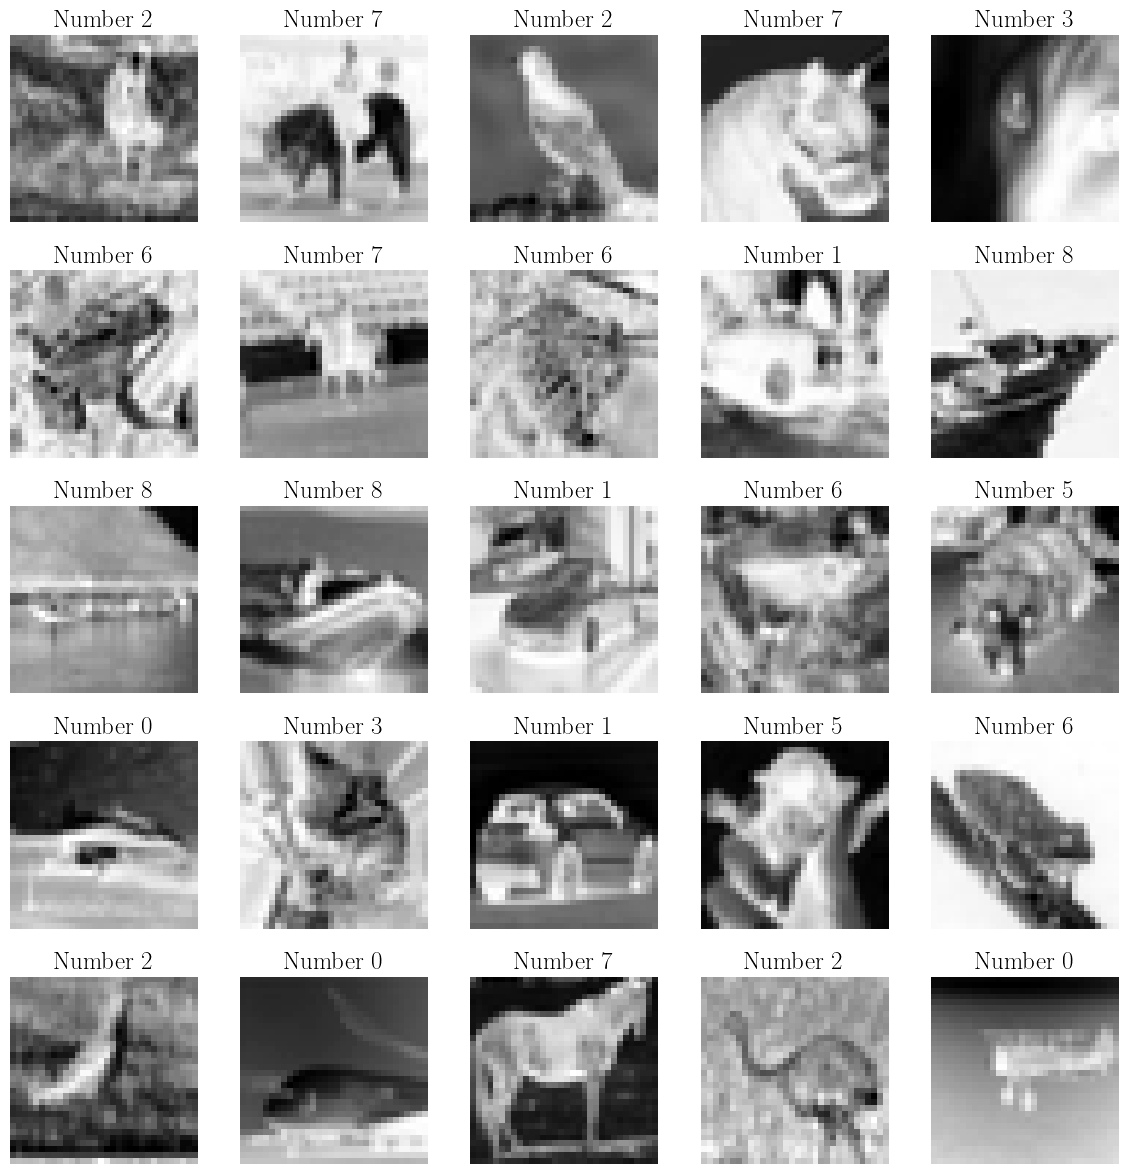

In [34]:
import matplotlib.pyplot as plt
from matplotlib import cm

fig, axs = plt.subplots(5, 5, figsize = (12, 12))
plt.gray()

# loop through subplots and add mnist images
for i, ax in enumerate(axs.flat):
    ax.imshow(traindata[i].reshape((32, 32)), cmap=cm.gray_r)
    # ax.imshow(traindata[i], cmap=cm.gray_r)
    ax.axis('off')
    ax.set_title('Number {}'.format(trainlabels[i]))

## Data pre-processing

In [35]:
from numpy import linalg as LA
from sklearn.preprocessing import StandardScaler

### PCA

In [36]:
#step1
scaler = StandardScaler()
train = scaler.fit_transform(traindata)
test = scaler.fit_transform(testdata)

#step2
cov_train = np.cov(train.T)

#step3
eig_vals, eig_vecs = LA.eig(cov_train)

#step4
sort_indices = np.argsort(eig_vals)[::-1]
eig_vals = eig_vals[sort_indices]
eig_vecs = eig_vecs[:, sort_indices]

#step5
k = 10 ## The number of features after PCA
eig_vec = eig_vecs[:, :k]


#step6
train_pca = np.real(np.dot(train, eig_vec))
test_pca = np.real(np.dot(test, eig_vec))

### Renormalize each feature

In [37]:
f_scale =[]
f_min =[]
x_train_lst = train_pca
x_test_lst = test_pca
Norm=np.pi/2
for i in range(0 ,len(x_train_lst[0])) :
  tg = [x[i] for x in x_train_lst]
  f_scale.append(np.max(tg) - np.min(tg))
  f_min.append(np.min(tg))
trs_tr = []
for x in x_train_lst :
  rs = []
  for i , scale , min in zip(x ,f_scale , f_min) :
    rs.append((i-min)/scale*Norm)
  trs_tr.append(rs)
trs_t = []
for x in x_test_lst :
  rs = []
  for i , scale , min in zip(x ,f_scale , f_min) :
    rs.append((i-min)/scale*Norm)
  trs_t.append(rs)

train_pca = trs_tr
test_pca = trs_t
train_pca_q=trs_tr
test_pca_q=trs_t

train_pca=np.array(train_pca)
test_pca=np.array(test_pca)

## Construct Quantum Kernal

In [38]:
import time

In [39]:
C6 = 5.42e-24
desire_rabi = 8*np.pi *1e6
R0=(C6/desire_rabi)**(1/6)
dim=10

a=0.8
pos = [i * a*R0 for i in range(dim)]

In [40]:
# from tqdm.notebook import trange, tqdm

raby=1
t=np.pi
operator_list = [[] for i in range(dim)]
matrix = np.ones([dim ,dim])
for idx ,x in enumerate(matrix) :
    for idy ,y in enumerate(x) :
        operator_list[idx].append(Q.form_op([idx , idy] , Q.rr ,10))
op ="x"
tier=2
mode="quera"
# error=[0.005, 0.01,0.1]
error=None
start_time = time.time()
qx_train_lst = Q.Qmap(pos , dim ,t ,train_pca_q, raby,op,operator_list,tier, mode,error=error)
qx_test_lst = Q.Qmap(pos , dim ,t ,test_pca_q, raby,op,operator_list,tier, mode,error=error)
end_time=time.time()

In [41]:
cost_time=end_time-start_time
print(cost_time)

11.526147603988647


In [42]:
i=0
target_kernel = Q.get_q_kernel(qx_train_lst[i],qx_train_lst[i])

In [43]:
test_kernel = Q.get_q_kernel(qx_test_lst[i],qx_train_lst[i], status = "test")

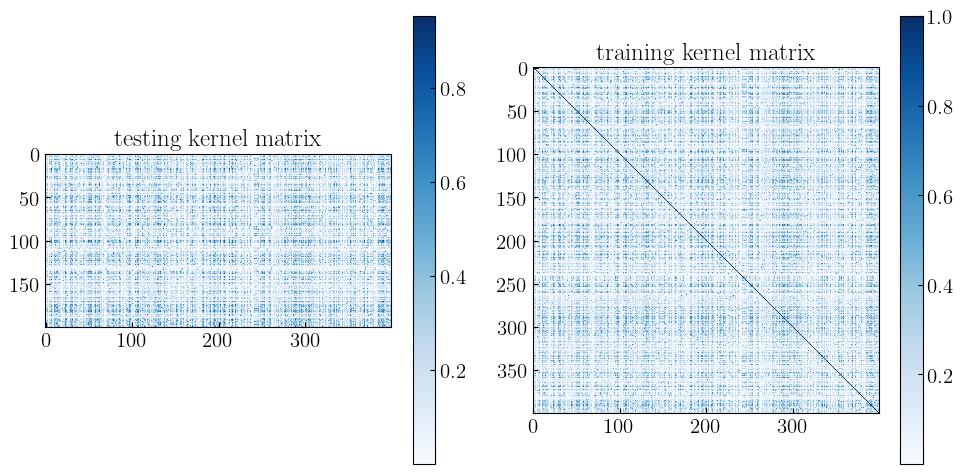

In [44]:
# Show quantum kernel matrix 
Q.show_kmatrix(train = target_kernel , test = test_kernel,name = "")

## Supported Vector Machine

In [45]:
from sklearn.svm import SVC

### Linear kernel

In [46]:
clf = SVC(kernel="linear",C=10.0)
clf.fit(train_pca, trainlabels)

SVC(C=10.0, kernel='linear')

### rbf kernel

In [47]:
clf = SVC(kernel="rbf",C=1.0)
clf.fit(train_pca, trainlabels)
y_pred = clf.predict(test_pca)
accuracy = np.mean(y_pred == testlabels)
print("Accuracy:", accuracy)

Accuracy: 0.235


In [48]:
C_list = [0.1, 0.5, 1.0, 5.0, 10.0]
for c in C_list:
  clf = SVC(kernel="rbf",C=c)
  clf.fit(train_pca, trainlabels)
  y_pred = clf.predict(test_pca)
  accuracy = np.mean(y_pred == testlabels)
  print("C={},Accuracy:{}".format(c,accuracy))
  print("\n")
#C represents the penalty coefficient for misclassification,A larger value of C will make the model strictly classify all samples correctly.
#C=10 give me the best accurarcy

C=0.1,Accuracy:0.08


C=0.5,Accuracy:0.205


C=1.0,Accuracy:0.235


C=5.0,Accuracy:0.245


C=10.0,Accuracy:0.23




### quantum kernel

In [49]:
clf = SVC(kernel="precomputed",C=10.0)
clf.fit(target_kernel, trainlabels)

SVC(C=10.0, kernel='precomputed')

In [50]:
y_pred = clf.predict(test_kernel)
accuracy = np.mean(y_pred == testlabels)
print("Accuracy:", accuracy)

Accuracy: 0.245
